<img src=https://images.squarespace-cdn.com/content/v1/56a7b1d0841aba91dc0e825a/1484761951212-GJLZPR3BBVG1FOQXRCPX/ke17ZwdGBToddI8pDm48kDITAuO7WvGYe_HtkNx7UXUUqsxRUqqbr1mOJYKfIPR7LoDQ9mXPOjoJoqy81S2I8N_N4V1vUb5AoIIIbLZhVYxCRW4BPu10St3TBAUQYVKcQbIjqAfhDXNkvlGRG3YzfcUFWQufmCUNtpzqkVhTQlW_0KK_D1La8oUscKbt8gvv/UNC+Charlote+Logo.png width="500">

# Deep Learning Tutorial: Generating Names with a Character-Level RNN

*************************************************************
**Original Author**: `Sean Robertson` https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

**Adapted by**: `Erfan Al-Hossami` <ealhossa@uncc.edu> for the Introduction to Natural Language Processing course at UNC Charlotte.

In this tutorial we will be generating names given a language - see below for examples:

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun


We are still hand-crafting a small RNN with a few linear layers. We input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a "language model".

**Additional References:**

-  https://pytorch.org/ For installation instructions
-  <https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html> to get started with PyTorch in general


It would also be useful to know about RNNs and how they work:

-  **The Unreasonable Effectiveness of Recurrent Neural Networks** <https://karpathy.github.io/2015/05/21/rnn-effectiveness/>-->
   shows a bunch of real life examples
-  **Understanding LSTM Networks** <https://colah.github.io/posts/2015-08-Understanding-LSTMs/> -->
   is about LSTMs specifically but also informative about RNNs in
   general
- **Classifying text with RNN's Tutorial** <https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb>

Preparing the Data
==================

Firstly:
   Download the data from <https://download.pytorch.org/tutorial/data.zip> -->
   and extract it to the current directory.



In [1]:
# uncomment line below if you have MAC/Linux OS but dont have wget installed
#!brew install wget
# If you have a mac/Linux run this command to automatically download the file and uzip
#Otherwise download it from the url and extract it to current notebook directory

# !wget https://download.pytorch.org/tutorial/data.zip
# !unzip data.zip
# !rm -r data.zip 

In [2]:
#!ls

The dataset consists of plain text files ``data/names/[Language].txt`` with one name per line. We split lines into an array, convert Unicode to ASCII, and end up with a dictionary ``{language: [names ...]}``.

In [3]:
#%cd data/names
#!ls

In [4]:
#!cat Arabic.txt

In [5]:
#%cd ../..
#!ls

In [6]:
%matplotlib inline

In [7]:
# Uncomment me if you're using macOS and your kernel keeps dying/restarting
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [8]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'): 
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
# Helps in standardizing characters - converts letters to ASCII characters
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


Creating the Network
====================

The category tensor is a one-hot vector for the language type just like
the letter input.

We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I added a second linear layer ``o2o`` (after combining hidden and
output) to give it more muscle to work with. There's also a dropout
layer, which `randomly zeros parts of its input` <https://arxiv.org/abs/1207.0580> --> with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting.
Here we're using it towards the end of the network to purposely add some
chaos and increase sampling variety. Next, we will review the RNN model again.

![alt](https://i.imgur.com/jzVrf7f.png)

In [9]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Training
=========
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




In [10]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

![alt](https://i.imgur.com/JH58tXY.png)

The category tensor is a one-hot
tensor <https://en.wikipedia.org/wiki/One-hot> --> of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




In [11]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




In [12]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [13]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1) # reshapes the vector into a 2d array (4,) to (1,4)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [14]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




In [15]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 50000
print_every = 1000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 6s (1000 2%) 3.3963
0m 22s (2000 4%) 2.5814
0m 35s (3000 6%) 3.0516
0m 44s (4000 8%) 3.1512
0m 51s (5000 10%) 2.9702
0m 56s (6000 12%) 2.4828
1m 0s (7000 14%) 3.2519
1m 5s (8000 16%) 2.6929
1m 9s (9000 18%) 2.3296
1m 13s (10000 20%) 2.8969
1m 18s (11000 22%) 2.2616
1m 27s (12000 24%) 2.3978
1m 46s (13000 26%) 2.8635
1m 55s (14000 28%) 2.9018
2m 15s (15000 30%) 2.8383
2m 32s (16000 32%) 2.4839
2m 40s (17000 34%) 3.7256
2m 49s (18000 36%) 2.7930
2m 58s (19000 38%) 1.9444
3m 3s (20000 40%) 2.0999
3m 11s (21000 42%) 2.5814
3m 19s (22000 44%) 3.0662
3m 28s (23000 46%) 1.1035
3m 47s (24000 48%) 3.1635
4m 13s (25000 50%) 2.9203
4m 25s (26000 52%) 2.7457
4m 34s (27000 54%) 2.1021
4m 42s (28000 56%) 2.4360
4m 51s (29000 57%) 1.8809
4m 57s (30000 60%) 2.8132
5m 15s (31000 62%) 1.7225
5m 36s (32000 64%) 2.5945
5m 47s (33000 66%) 2.7988
5m 56s (34000 68%) 1.8022
6m 6s (35000 70%) 2.5009
6m 11s (36000 72%) 2.9742
6m 18s (37000 74%) 4.1521
6m 24s (38000 76%) 2.4124
6m 34s (39000 78%) 2.4658
6m 40

Plotting the Losses
-------------------

Plotting the historical loss from all\_losses shows the network
learning:




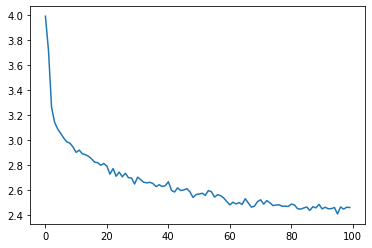

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Sampling the Network
====================

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

**Try:**
   Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.




In [17]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(u'Language: {}\t Starting Letter: {} \t Name: {}'.format(category,start_letter,sample(category, start_letter)))
samples('Russian', 'RUS')

samples('German', 'GER') 


Language: Russian	 Starting Letter: R 	 Name: Ronon
Language: Russian	 Starting Letter: U 	 Name: Uanton
Language: Russian	 Starting Letter: S 	 Name: Santon
Language: German	 Starting Letter: G 	 Name: Gang
Language: German	 Starting Letter: E 	 Name: Eang
Language: German	 Starting Letter: R 	 Name: Ronger


Practice!
=========
- Try generating names for 3 other languages!

In [19]:
# TODO: Print 3 more languages

More Practice!
=========

-  Try with a different dataset of category -> line, for example:
   -  Country -> City
   - Dataset: <https://github.com/datasets/world-cities/blob/master/data/world-cities.csv>

-  Get better results with a bigger and/or better shaped network
   -  Try the nn.LSTM and nn.GRU layers
   -  Combine multiple of these RNNs as a higher level network


